In [1]:
import mujoco
import mediapy as media
import numpy as np 
renderer = None

In [6]:
model = mujoco.MjModel.from_xml_path("kuka_iiwa_14/scene.xml")
data = mujoco.MjData(model)
if renderer is None:
    renderer = mujoco.Renderer(model, width=800, height=600)

In [7]:

class ActuatorMotor:
    def __init__(self, torque_range = [-100,100]) -> None:
        self.range = torque_range
        self.dyn = np.array([1, 0, 0])
        self.gain = np.array([1, 0, 0])
        self.bias = np.array([0, 0, 0])

    def __repr__(self) -> str:
        return f"ActuatorMotor(dyn={self.dyn}, gain={self.gain}, bias={self.bias})"
# data.ctrl = 
def update_actuator(model, actuator_id, actuator):
    """
    Update actuator in model
    model - mujoco.MjModel
    actuator_id - int or str (name) (for reference see, named access to model elements)
    actuator - ActuatorMotor, ActuatorPosition, ActuatorVelocity
    """
    model.actuator(actuator_id).dynprm = np.zeros(len(model.actuator(actuator_id).dynprm))
    model.actuator(actuator_id).gainprm = np.zeros(len(model.actuator(actuator_id).gainprm))
    model.actuator(actuator_id).biasprm = np.zeros(len(model.actuator(actuator_id).biasprm))
    model.actuator(actuator_id).ctrlrange = actuator.range 
    model.actuator(actuator_id).dynprm[:3] = actuator.dyn
    model.actuator(actuator_id).gainprm[:3] = actuator.gain
    model.actuator(actuator_id).biasprm[:3] = actuator.bias

In [10]:
# mujoco.mj_reset(model, data)

mujoco.mj_resetData(model, data)  # Reset state and time.
# setup simulation
q_des = np.array([2.6,1.2,-2.1,0.7,0.7,0.7, 0.1])

torque_motor = ActuatorMotor()

for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, torque_motor)

duration = 2.3  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
history_q = []
frames = []
while data.time < duration:
    q = data.qpos.copy()
    dq = data.qvel.copy()
    # print(q)
    # print(data.ctrl)
    data.ctrl[:] = 250.*(q_des - q) - 50.*dq #np.zeros(model.nu)
    history_q.append(data.qpos.copy())

    # print(q)
    # print(data.ctrl)
    mujoco.mj_step(model, data)
    # Do your control here!
    # data.qpos, data.qvel 
    # 
    # print(data.time, data.qpos, data.qvel)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)
        
media.show_video(frames, fps=framerate)

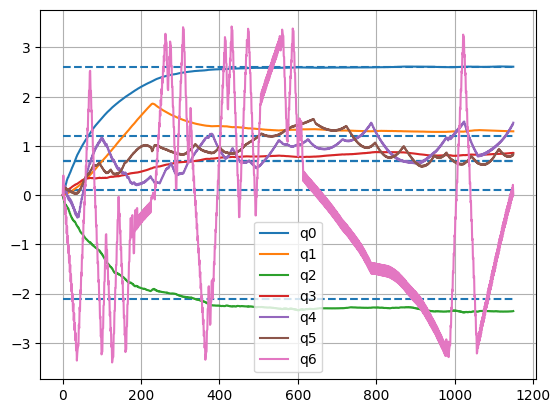

In [11]:
import matplotlib.pyplot as plt

history_q = np.array(history_q)

plt.hlines(q_des, 0, len(history_q), linestyles="dashed")
plt.plot(history_q, label=["q" + str(i) for i in range(7)])
plt.grid()
plt.legend()
plt.show()